# Getting started

In this Jupyter Notebook we illustrate the core functionalities of **do mpc**.

We start by importing the required modules, most notably `do_mpc`. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

# Add to path:
import sys
sys.path.append('../../')

# Import do_mpc package:
import do_mpc

## Creating the model

First, we need to decide on the model type. For the given example, we are working with a continuous model.

In [3]:
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model(model_type)

### Model variables

The next step is to define the model variables. It is important to define the variable type, name and optionally shape (default is scalar variable). The following types are available:

|Long name  |                short name | Remark         |
|-----------|---------------------------|----------------|
|``states`` |                  ``_x``   |    Required    |
|``inputs`` |                  ``_u``   |    Required    |
|``algebraic``  |              ``_z``   |    Optional    |
|``parameter``  |              ``_p``   |    Optional    |
|``timevarying_parameter`` |   ``_tvp`` |    Optional    |


In [4]:
phi_1 = model.set_variable(var_type='_x', var_name='phi_1', shape=(1,1))
phi_2 = model.set_variable(var_type='_x', var_name='phi_2', shape=(1,1))
phi_3 = model.set_variable(var_type='_x', var_name='phi_3', shape=(1,1))
# Variables can also be vectors:
dphi = model.set_variable(var_type='_x', var_name='dphi', shape=(3,1))
# Two states for the desired (set) motor position:
phi_m_1_set = model.set_variable(var_type='_u', var_name='phi_m_1_set')
phi_m_2_set = model.set_variable(var_type='_u', var_name='phi_m_2_set')
# Two additional states for the true motor position:
phi_1_m = model.set_variable(var_type='_x', var_name='phi_1_m', shape=(1,1))
phi_2_m = model.set_variable(var_type='_x', var_name='phi_2_m', shape=(1,1))

### Model measurements

In [5]:
# State measurements
phi_1_meas = model.set_meas('phi_1_meas', phi_1)
phi_2_meas = model.set_meas('phi_2_meas', phi_2)

# Input measurements
phi_m_1_set_meas = model.set_meas('phi_m_1_set_meas', phi_m_1_set)
phi_m_2_set_meas = model.set_meas('phi_m_2_set_meas', phi_m_2_set)

### Model parameters

Next we **define parameters**. Known values can and should be hardcoded but with robust MPC in mind, we define uncertain parameters explictly. We assume that the inertia is such an uncertain parameter and hardcode the spring constant and friction coefficient.

In [6]:
# As shown in the table above, we can use Long names or short names for the variable type.
Theta_1 = model.set_variable('parameter', 'Theta_1') 
Theta_2 = model.set_variable('parameter', 'Theta_2')
Theta_3 = model.set_variable('parameter', 'Theta_3')

c = np.array([2.697,  2.66,  3.05, 2.86])*1e-3
d = np.array([6.78,  8.01,  8.82])*1e-5

### Right-hand-side equation
Finally, we set the right-hand-side of the model by calling `model.set_rhs(var_name, expr)` with the `var_name` from the state variables defined above and an expression in terms of $x, u, z, p$. 

In [7]:
model.set_rhs('phi_1', dphi[0])
model.set_rhs('phi_2', dphi[1])
model.set_rhs('phi_3', dphi[2])

For the vector valued state `dphi` we need to concatenate symbolic expressions. We import the symbolic library CasADi: 

In [8]:
from casadi import *

In [9]:
dphi_next = vertcat(
    -c[0]/Theta_1*(phi_1-phi_1_m)-c[1]/Theta_1*(phi_1-phi_2)-d[0]/Theta_1*dphi[0],
    -c[1]/Theta_2*(phi_2-phi_1)-c[2]/Theta_2*(phi_2-phi_3)-d[1]/Theta_2*dphi[1],
    -c[2]/Theta_3*(phi_3-phi_2)-c[3]/Theta_3*(phi_3-phi_2_m)-d[2]/Theta_3*dphi[2],
)

model.set_rhs('dphi', dphi_next)

In [10]:
tau = 1e-2 
model.set_rhs('phi_1_m', 1/tau*(phi_m_1_set - phi_1_m))
model.set_rhs('phi_2_m', 1/tau*(phi_m_2_set - phi_2_m))

The model setup is completed by calling `model.setup_model()`:

In [11]:
model.setup_model()

After calling `model.setup_model()` we cannot define further variables etc.

## Configuring the Moving Horizon Estimator

In [12]:
mhe = do_mpc.mhe(model, ['Theta_2'])

### MHE parameters:

In [13]:
setup_mhe = {
    't_step': 0.1,
    'n_horizon': 10,
    'store_full_solution': True,
    'meas_from_data': True
}
mhe.set_param(**setup_mhe)

### Cost Function

In [14]:
y_meas = mhe.vars['_y_meas']
y_calc = mhe.vars['_y_calc']

dy = y_meas.cat-y_calc.cat
obj = dy.T@dy

x_0 = mhe.vars['_x']
x_prev = mhe.vars['_x_prev']
p_0 = mhe.vars['_p_est']
p_prev = mhe.vars['_p_prev']

dx = x_0.cat - x_prev.cat
dp = p_0.cat - p_prev.cat

arrival_cost = 1e-4*dx.T@dx + 1e-4*dp.T@dp


mhe.set_objective(obj, arrival_cost)

### Fixed parameters

In [15]:
p_template_mhe = mhe.get_p_template()

In [16]:
def p_fun_mhe(t_now):
    p_template_mhe['Theta_1'] = 2.25e-4
    p_template_mhe['Theta_3'] = 2.25e-4
    return p_template_mhe

In [17]:
mhe.set_p_fun(p_fun_mhe)

### Setup

In [18]:
mhe.setup()

## Configuring the Simulator
In many cases a developed control approach is first tested on a simulated system. **do mpc** responds to this need with the `do_mpc.simulator` class. The `simulator` uses state-of-the-art DAE solvers, e.g. Sundials [CVODE](https://computing.llnl.gov/projects/sundials/cvode) to solve the DAE equations defined in the supplied `do_mpc.model`. This will often be the same model as defined for the `optimizer` but it is also possible to use a more complex model of the same system.

In this section we demonstrate how to setup the `simulator` class for the given example. We initilize the class with the previously defined `model`:

In [19]:
simulator = do_mpc.simulator(model)

### Simulator parameters

Next, we need to parametrize the `simulator`. Please see the API documentation for `simulator.set_param()` for a full description of available parameters and their meaning. Many parameters already have suggested default values. Most importantly, we need to set `t_step`. We choose the same value as for the `optimizer`.

In [20]:
# Instead of supplying a dict with the splat operator (**), as with the optimizer.set_param(),
# we can also use keywords (and call the method multiple times, if necessary):
simulator.set_param(t_step = 0.1)

### Uncertain parameters
In the `model` we have defined the inertia of the masses as parameters, for which we have choosen multiple scenarios in the `optmizer`. The `simulator` is now parametrized to simulate with the "true" values at each timestep. In the most general case, these values can change, which is why we need to supply a function that can be evaluted at each time to obtain the current values. 
**do mpc** requires this function to have a specific return structure which we obtain first by calling:

In [21]:
p_template_sim = simulator.get_p_template()

This object is a CasADi structure:

which can be indexed with the following keys:

In [22]:
p_template_sim.keys()

['default', 'Theta_1', 'Theta_2', 'Theta_3']

We need to now write a function which returns this structure with the desired numerial values. For our simple case:

In [23]:
def p_fun_sim(t_now):
    p_template_sim['Theta_1'] = 2.25e-4
    p_template_sim['Theta_2'] = 2.25e-4
    p_template_sim['Theta_3'] = 2.25e-4
    return p_template_sim

This function is now supplied to the `simulator` in the following way:

In [24]:
simulator.set_p_fun(p_fun_sim)

### Setup
Similarly to the `optimizer` we need to call `simulator.setup()` to finalize the setup of the simulator.

In [25]:
simulator.setup()

## Creating the control loop
In theory, we could now also create an estimator but for this concise example we just assume direct state-feedback. This means we are now ready to setup and run the control loop. 
The control loop consists of running the optimizer with the current state ($x_0$) to obtain the current control input ($u_0$) and then running the simulator with the current control input ($u_0$) to obtain the next state.

As discussed before, we setup a controller for regulating a triple-mass-spring system. To show some interesting control action we choose an arbitrary initial state $x_0\neq 0$:

In [26]:
x0 = np.pi*np.array([1, 1, -1.5, 1, -1, 1, 0, 0]).reshape(-1,1)

In [27]:
x0_mhe = x0*(1+0.5*np.random.randn(8,1))

and use the `.set_initial_state()` method to set the initial state (which also calls `optimizer.set_initial_guess()`.

In [28]:
simulator.set_initial_state(x0, reset_history=True)
mhe.set_initial_state(x0_mhe ,p_est0=np.array([1e-4]), reset_history=True)

### Setting up the Graphic
To investigate the controller performance **AND** the MPC predictions, we are using the **do mpc** `graphics` module. This versatile tool allows us to conveniently configure a user-defined plot based on Matplotlib and visualize the results stored in the `optimizer.data`, `simulator.data` (and if applicable `estimator.data`) objects. 

We start by importing matplotlib:

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True

And initializing the `graphics module`:

In [30]:
graphics = do_mpc.graphics()

Next, we create a `figure` and obtain its `axis` object. Matplotlib offers multiple alternative ways to obtain an `axis` object, e.g. [subplots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html), [subplot2grid](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot2grid.html), or simply [gca](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html). We use `subplots`:

In [31]:
%%capture 
# We just want to create the plot and not show it right now. This "inline magic" surpresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

Most important API element for setting up the `graphics` module is `graphics.add_line`, which mimics the API of `model.add_variable`, except that we also need to pass an `axis`. 

Note that we are only configuring the `graphics` module without showing anything just yet.

In [32]:
%%capture
# Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
graphics.add_line(var_type='_x', var_name='phi_1', axis=ax[0])
graphics.add_line(var_type='_x', var_name='phi_2', axis=ax[0])
graphics.add_line(var_type='_x', var_name='phi_3', axis=ax[0])
ax[0].set_ylabel('angle position [rad]')

# Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
graphics.add_line(var_type='_u', var_name='phi_m_1_set', axis=ax[1])
graphics.add_line(var_type='_u', var_name='phi_m_2_set', axis=ax[1])
ax[1].set_ylabel('motor angle [rad]')

ax[1].set_xlabel('time [s]')

### Running the simulator
We start investigating the **do mpc** simulator and the `graphics` package by simulating the autonomous system without control inputs ($u = 0$). This can be done as follows:

In [ ]:
u0 = np.zeros((2,1))
for i in range(50):
    y0 = simulator.make_step(u0)
    x0 = mhe.make_step(y0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1100
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      127

Total number of variables............................:      373
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1100
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      127

Total number of variables............................:      373
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      320
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9942728e+01 2.26e-14 1.08e-01  -1.0 0.00e+00    -  0.00e+00 0.

  61  1.8341742e+01 1.61e-08 1.14e-02  -5.7 1.06e-01  -1.0 1.00e+00 1.00e+00f  1
  62  1.8281823e+01 6.36e-08 4.13e-03  -5.7 1.15e-01  -1.4 1.00e+00 1.00e+00f  1
  63  1.8269198e+01 2.35e-07 1.22e-03  -5.7 1.02e-01  -1.9 1.00e+00 1.00e+00f  1
  64  1.8267502e+01 1.61e-06 3.92e-04  -5.7 9.82e-02  -2.4 1.00e+00 1.00e+00f  1
  65  1.8266641e+01 1.14e-05 3.19e-04  -5.7 2.43e-01  -2.9 1.00e+00 1.00e+00f  1
  66  1.8264461e+01 4.71e-05 2.33e-04  -5.7 5.26e-01  -3.4 1.00e+00 1.00e+00f  1
  67  1.8259064e+01 5.13e-06 2.14e-04  -5.7 1.45e+00  -3.8 1.00e+00 1.00e+00f  1
  68  1.8247820e+01 7.38e-05 1.72e-04  -5.7 3.50e+00  -4.3 1.00e+00 1.00e+00f  1
  69  1.8233922e+01 5.83e-05 9.85e-05  -5.7 6.00e+00  -4.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.8226456e+01 9.06e-06 3.57e-05  -5.7 6.52e+00  -5.3 1.00e+00 1.00e+00f  1
  71  1.8222329e+01 2.37e-05 1.85e-05  -5.7 9.55e+00  -5.7 1.00e+00 1.00e+00f  1
  72  1.8217475e+01 2.97e-04

 166  1.8193931e+01 2.68e-01 2.24e-01  -8.6 4.51e-01  -0.5 1.00e+00 1.00e+00h  1
 167  1.8203982e+01 1.34e-01 1.13e-01  -8.6 3.18e-01  -1.0 1.00e+00 5.00e-01h  2
 168  1.8209798e+01 6.71e-02 5.69e-02  -8.6 1.55e-01  -1.4 1.00e+00 5.00e-01h  2
 169  1.8217483e+01 1.49e-08 8.94e-04  -8.6 7.51e-02  -1.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.8217388e+01 2.99e-12 7.94e-05  -8.6 2.00e-02  -2.4 1.00e+00 1.00e+00F  1
 171  1.8217353e+01 3.62e-10 6.20e-05  -8.6 4.18e-02  -2.9 1.00e+00 1.00e+00F  1
 172  1.8216983e+01 1.03e-07 3.18e-03  -8.6 3.33e-01  -3.4 1.00e+00 1.00e+00F  1
 173  1.8216970e+01 1.09e-05 3.09e-03  -8.6 1.37e-01  -1.1 1.00e+00 3.12e-02f  6
 174  1.8216871e+01 7.50e-06 5.06e-03  -8.6 2.23e-02  -0.7 1.00e+00 1.00e+00H  1
 175  1.8216805e+01 2.33e-04 6.96e-03  -8.6 1.22e-02  -0.3 1.00e+00 1.00e+00h  1
 176  1.8216750e+01 6.63e-05 7.63e-03  -8.6 5.30e-03   0.2 1.00e+00 1.00e+00h  1
 177  1.8216472e+01 5.05e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  1.8217392e+01 3.76e-06 4.32e-06  -8.6 1.10e-01  -4.7 1.00e+00 1.00e+00h  1
 261  1.8222646e+01 2.56e-08 5.10e-03  -8.6 7.10e+00  -5.1 1.00e+00 1.00e+00H  1
 262  1.8217575e+01 1.96e-08 3.50e-04  -8.6 6.02e+00  -5.6 1.00e+00 1.00e+00F  1
 263  1.8216813e+01 2.89e-03 2.43e-03  -8.6 1.42e+01  -5.2 1.00e+00 2.50e-01f  3
 264  1.8217035e+01 1.45e-03 1.22e-03  -8.6 1.81e+00  -5.7 1.00e+00 5.00e-01h  2
 265  1.8217389e+01 3.49e-06 1.61e-06  -8.6 1.56e+00  -6.1 1.00e+00 1.00e+00h  1
 266  1.8217349e+01 2.38e-09 5.68e-05  -8.6 3.54e+00  -6.6 1.00e+00 1.00e+00H  1
 267  1.8217340e+01 1.34e-06 2.56e-06  -8.6 7.64e-01  -7.1 1.00e+00 1.00e+00h  1
 268  1.8217342e+01 6.56e-08 9.88e-08  -8.6 2.38e-01  -7.6 1.00e+00 1.00e+00h  1
 269  1.8217342e+01 3.66e-10 7.16e-10  -8.6 2.05e-02  -8.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 269

                                   (scaled)                 (unscaled)
Object

  32  1.1137886e+01 1.76e-06 6.49e-01  -8.6 2.81e+02  -6.9 1.00e+00 3.91e-03f  9
  33  1.1137200e+01 2.12e-06 6.49e-01  -8.6 4.90e+02  -7.3 1.00e+00 9.77e-04f 11
  34  1.1022122e+01 6.05e-01 1.38e+02  -8.6 6.58e+02  -7.8 1.00e+00 2.50e-01f  3
  35  1.1094329e+01 3.29e-01 6.91e+01  -8.6 6.48e-02   0.0 1.00e+00 1.00e+00h  1
  36  1.1202570e+01 2.11e-01 3.41e+01  -8.6 9.11e-02   0.5 1.00e+00 1.00e+00h  1
  37  1.1320290e+01 1.91e-01 2.04e+01  -8.6 1.91e-01   0.9 1.00e+00 5.00e-01h  2
  38  1.1344028e+01 1.91e-01 1.93e+01  -8.6 1.32e+00   1.3 1.00e+00 1.56e-02h  7
  39  1.1386406e+01 1.86e-01 1.30e+01  -8.6 7.72e-01   1.7 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.1328494e+01 1.38e-01 6.53e+00  -8.6 1.24e+00   2.2 1.00e+00 1.00e+00h  1
  41  1.1028016e+01 7.02e-07 1.21e+01  -8.6 2.48e-01   1.7 1.00e+00 1.00e+00h  1
  42  1.1028007e+01 1.73e-10 5.40e-03  -8.6 3.07e-04   1.2 1.00e+00 1.00e+00h  1
  43  1.1027986e+01 1.84e-09

 127  1.0999737e+01 2.88e-03 2.50e-01  -8.6 2.29e-02   0.6 1.00e+00 1.00e+00h  1
 128  1.0996172e+01 4.97e-05 6.82e-02  -8.6 6.67e-03   1.0 1.00e+00 1.00e+00h  1
 129  1.0986915e+01 9.23e-03 2.38e-01  -8.6 1.74e-02   0.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  1.0950672e+01 9.18e-02 5.69e+00  -8.6 6.91e-02   0.1 1.00e+00 1.00e+00h  1
 131  1.0860655e+01 8.94e-05 3.38e-01  -8.6 1.72e-01  -0.4 1.00e+00 1.00e+00h  1
 132  1.0587423e+01 6.68e-01 2.12e+00  -8.6 5.45e-01  -0.9 1.00e+00 1.00e+00f  1
 133  9.3763455e+00 2.04e+00 7.17e-01  -8.6 3.03e+00  -1.4 1.00e+00 1.00e+00h  1
 134  8.7246608e+00 1.92e+00 6.00e+00  -8.6 4.39e+00   0.9 1.00e+00 1.00e+00h  1
 135  1.1591905e+01 3.40e-08 7.87e+00  -8.6 3.29e+00   0.4 1.00e+00 1.00e+00h  1
 136  1.1425387e+01 2.08e-09 3.82e-02  -8.6 4.78e-02  -0.1 1.00e+00 1.00e+00f  1
 137  1.1210004e+01 1.01e-08 2.21e-02  -8.6 8.31e-02  -0.6 1.00e+00 1.00e+00f  1
 138  1.1064568e+01 3.17e-08

 234  1.1015439e+01 2.12e-06 1.01e-05  -8.6 2.50e-01  -4.4 1.00e+00 1.00e+00h  1
 235  1.1015301e+01 4.62e-07 9.29e-06  -8.6 7.18e-01  -4.9 1.00e+00 1.00e+00h  1
 236  1.1014934e+01 1.34e-05 2.18e-05  -8.6 2.04e+00  -5.4 1.00e+00 1.00e+00h  1
 237  1.1014499e+01 2.10e-03 9.31e-04  -8.6 7.64e+00  -5.8 1.00e+00 1.00e+00h  1
 238  1.1014735e+01 1.83e-03 8.15e-04  -8.6 5.38e+00  -6.3 1.00e+00 1.25e-01h  4
 239  1.1014892e+01 1.60e-03 6.96e-04  -8.6 1.34e+01  -6.8 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  1.1014913e+01 1.58e-03 6.85e-04  -8.6 6.82e+00  -6.4 1.00e+00 1.56e-02h  7
 241  1.1026484e+01 2.73e-09 6.95e-03  -8.6 3.26e+01  -6.8 1.00e+00 1.00e+00H  1
 242  1.0746175e+01 6.07e-02 2.18e+01  -8.6 7.57e+01  -7.3 1.00e+00 1.00e+00F  1
 243  1.0736276e+01 1.21e-02 7.43e+00  -8.6 7.81e-03   0.5 1.00e+00 1.00e+00h  1
 244  1.0663843e+01 4.94e-03 3.44e+00  -8.6 6.52e-02   0.0 1.00e+00 1.00e+00h  1
 245  1.0516438e+01 4.69e-02

   3  5.6951716e+00 2.85e-02 1.57e+01  -2.5 5.84e+00  -3.0 1.00e+00 1.00e+00f  1
   4  4.0807115e+00 3.62e-01 6.85e+02  -2.5 1.61e+01  -3.4 1.00e+00 1.00e+00f  1
   5  1.9155314e+00 7.42e+01 1.90e+05  -2.5 5.70e+01  -3.9 1.00e+00 1.00e+00f  1
   6  4.5618693e+00 7.36e+01 1.73e+05  -2.5 2.47e+02  -4.4 1.00e+00 6.25e-02h  5
   7  1.0352382e+01 5.50e+01 1.16e+05  -2.5 3.94e+01  -3.1 1.00e+00 1.00e+00h  1
   8  1.3907627e+01 5.47e+01 1.13e+05  -2.5 7.13e+02  -3.5 1.00e+00 1.56e-02h  7
   9  1.9251487e+01 5.44e+01 1.10e+05  -2.5 4.06e+02  -3.1 1.00e+00 1.56e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4897685e+01 5.40e+01 1.07e+05  -2.5 3.17e+02  -2.7 1.00e+00 1.56e-02h  7
  11  4.8780918e+01 5.29e+01 8.65e+04  -2.5 1.34e+02  -2.3 1.00e+00 1.25e-01h  4
  12  2.3721553e+02 3.40e+01 5.32e+04  -2.5 3.91e+01  -0.9 1.00e+00 1.00e+00h  1
  13  4.2508740e+02 2.35e+01 7.39e+03  -2.5 3.31e+01   0.4 1.00e+00 1.00e+00h  1
  14  4.2587054e+02 2.35e+01

  14  1.0140876e+01 7.36e-11 1.16e-10  -8.6 1.84e-02  -8.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:   1.0140876239829858e+01    1.0140876239829858e+01
Dual infeasibility......:   1.1564065078747390e-10    1.1564065078747390e-10
Constraint violation....:   7.3571824956049359e-11    7.3571824956049359e-11
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.1564065078747390e-10    1.1564065078747390e-10


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 15
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 15
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 14
Total CPU secs in IPOPT (w

We can visualize the resulting trajectory with the pre-defined graphic:

In [ ]:
graphics.plot_results(simulator.data)
graphics.plot_results(mhe.data)
# Show the figure:
fig

As desired, the motor angle (input) is constant at zero and the oscillating masses slowly come to a rest. Our control goal is to significantly shorten the time until the discs are stationary.

Remember the animation you saw above, of the uncontrolled system? This is where the data came from.

### Running the optimizer
To obtain the current control input we call `optimizer.make_step(x0)` with the current state ($x_0$):

In [34]:
u0 = optimizer.make_step(x0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19448
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1229

Total number of variables............................:     6408
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2435
                     variables with only upper bounds:        0
Total number of equ

Note that we obtained the output from IPOPT regarding the given optimal control problem (OCP). Most importantly we obtained `Optimal Solution Found`.

The configured `graphics` module is very useful to investigate the obtained solution by plotting the predicted system behavior. We simply need to call:

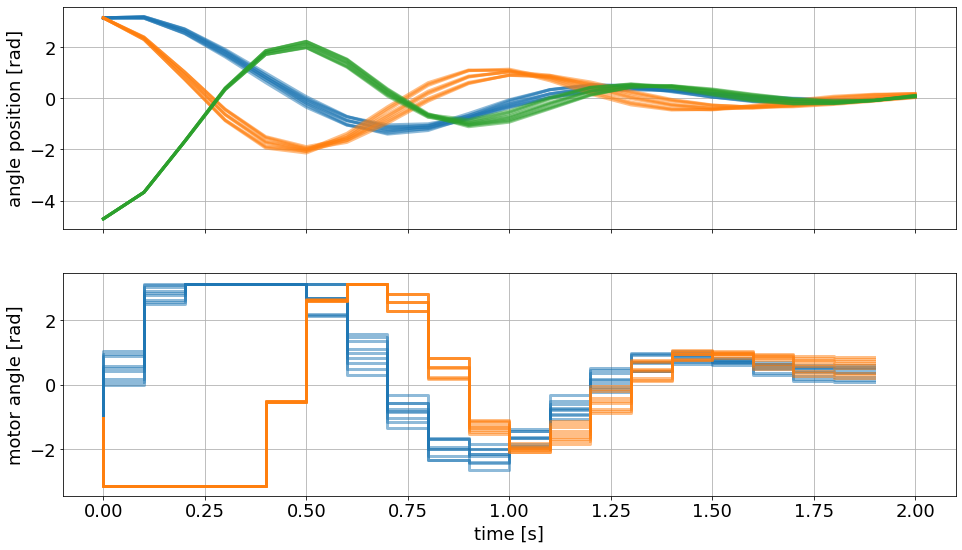

In [35]:
graphics.reset_axes()
lines = graphics.plot_predictions(optimizer.data, alpha=0.5)
# Autoscale the axis:
ax[0].relim() 
ax[0].autoscale() 
ax[1].relim() 
ax[1].autoscale() 
# Show the figure:
fig

We are seeing the predicted trajectories for the states and the optimal control inputs. Note that we are seeing different scenarios for the configured uncertain inertia of the three masses. 

We can also see that the solution is considering the defined upper and lower bounds. This is especially true for the inputs.

As a conclusion, the results look as expected and can be assessed in the closed-loop application.

### Running the control loop
Finally, we are now able to run the control loop as discussed above. We obtain the input from the `optimizer` and then run the `simulator`.

To make sure we start fresh, we reset the initial state and erase the history:

In [36]:
simulator.set_initial_state(x0, reset_history=True)
optimizer.set_initial_state(x0, reset_history=True)

This is the main-loop. We run 20 steps, whic is identical to the prediction horizon. Note that we use "capture" again, to surpress the output from IPOPT. 

It is usually suggested to display the output as it contains important information about the state of the solver.

In [37]:
%%capture
for i in range(20):
    u0 = optimizer.make_step(x0)
    x0 = simulator.make_step(u0)

We can now plot the previously shown prediction from time $t=0$, as well as the closed-loop trajectory from the simulator:

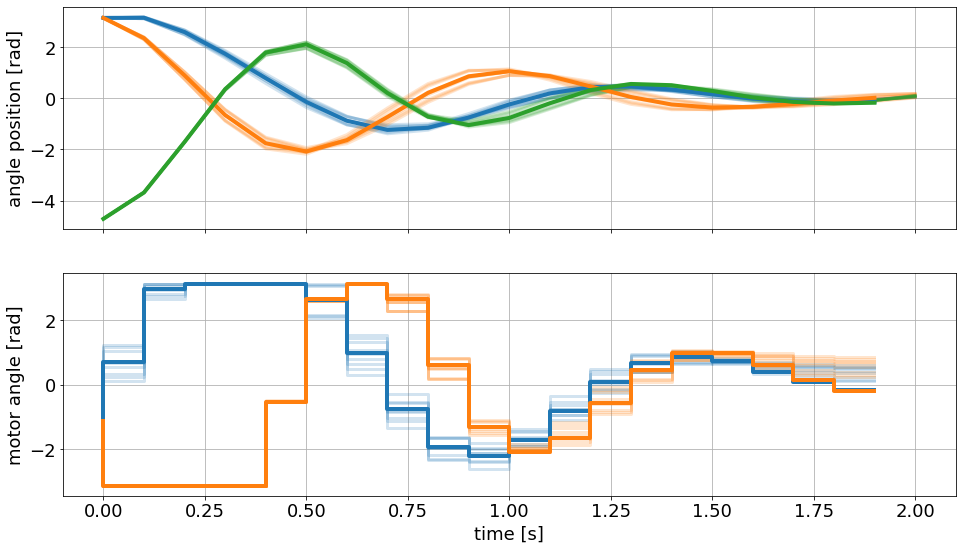

In [38]:
# Clear previous lines
graphics.reset_axes()
# Plot predictions from t=0
pred_lines = graphics.plot_predictions(optimizer.data, t_ind=0, linewidth=3, alpha=.2)
# Plot results until current time
res_lines = graphics.plot_results(simulator.data, linewidth=4, alpha=1)
fig

The simulated trajectory with the nominal value of the parameters follows almost exactly the nominal open-loop predictions. The simulted trajectory is bounded from above and below by further uncertain scenarios. 

## Data processing

### Saving and retrieving results

**do mpc** results can be stored and retrieved with the methods `save_results` and `load_results` from the `do_mpc.data` module. We start by importing these methods:

In [39]:
from do_mpc.data import save_results, load_results

The method `save_results` is passed a list of the **do mpc** objects that we want to store. In our case, the `optimizer` and `simulator` are available and configured. 

Note that by default results are stored in the subfolder `results` under the name `results.pkl`. Both can be changed and the folder is created if it doesn't exist already.

In [41]:
save_results([optimizer, simulator])

We investigate the content of the newly created folder:

In [42]:
import os
os.listdir('./results/')

['results.pkl']

Automatically, the `save_results` call will check if a file with the given name already exists. To avoid overwriting, the method prepends an index. If we save again, the folder contains:

In [43]:
save_results([optimizer, simulator])
os.listdir('./results/')

['001_results.pkl', 'results.pkl']

The pickled results can be loaded manually by writing:

```python
with open(file_name, 'rb') as f:
    results = pickle.load(f)
```

or by calling `load_results` with the appropriate `file_name` (and path). `load_results` contains simply the code above for more convenience.

In [44]:
results = load_results('./results/results.pkl')

The obtained `results` is a dictionary with the `data` objects from the passed **do mpc** modules. Such that:
`results['optimizer']` and `optimizer.data` contain the same information (similarly for `simulator` and, if applicable, `estimator`).

### Animating results
Animating MPC results, to compare prediction and closed-loop trajectories, allows for a very meaningful investigation of the obtained results.

**do mpc** significantly facilitates this process while working hand in hand with Matplotlib for full customizability. Obtaining publication ready animations is as easy as writing the following short blocks of code:

In [54]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update(t_ind):
    graphics.reset_axes()
    graphics.plot_results(simulator.data, t_ind=t_ind, linewidth=5)
    graphics.plot_predictions(optimizer.data, t_ind=t_ind, linestyle='--', linewidth=3)

The `graphics` module can also be used without restrictions with loaded **do mpc** data. This allows for convenient data post-processing, e.g. in a Jupyter Notebook.
With the `results` dict from above we have to write:

In [55]:
def update(t_ind):
    graphics.reset_axes()
    graphics.plot_results(results['simulator'], t_ind=t_ind, linewidth=5)
    graphics.plot_predictions(results['optimizer'], t_ind=t_ind, linestyle='--', linewidth=3)

In [56]:
anim = FuncAnimation(fig, update, frames=20, repeat=False)
gif_writer = ImageMagickWriter(fps=3)
#anim.save('anim.gif', writer=gif_writer)

Below we showcase the resulting gif file (not in real-time):
![SegmentLocal](anim.gif "segment")

Thank you, for following through this short example on how to use **do mpc**. We hope you find the tool and this documentation useful.

We suggest that you have a look at the API documentation for further details on the presented modules, methods and functions.

We also want to emphasize that we skipped over many details, further functions etc. in this introduction. Please have a look at our more complex examples to get a better impression of the possibilities with **do mpc**.